<a href="https://colab.research.google.com/github/sankardevisharath/amex-default-prediction/blob/master/notebooks/LGBMClassifier_on_agg_data_with_KMeansSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gc 

import numpy as np
import pandas as pd
import lightgbm as gbm
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_parquet(path='/content/drive/MyDrive/amex-default-prediction/data/aggr/customer-agg.parquet')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Columns: 920 entries, customer_ID to target
dtypes: float64(891), int64(26), object(3)
memory usage: 3.1+ GB


In [ ]:
columns = df.head().dtypes
columns[columns==object]


customer_ID    object
D_63_last      object
D_64_last      object
dtype: object

In [ ]:
cat_cols = ['D_63', 'D_64','B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_66', 'D_68']
TRAIN_LABELS_PATH = '/content/train_labels.csv'

In [ ]:
X = pd.DataFrame()
Y = pd.DataFrame()

enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df[['D_63_last', 'D_64_last']]=enc.fit(df[['D_63_last', 'D_64_last']])
df[['D_63_last', 'D_64_last']]=enc.transform(df[['D_63_last', 'D_64_last']])
df.fillna(0, inplace=True)
X= X.append(df.loc[:, ~df.columns.isin(['customer_ID', 'target'])])
Y = Y.append(df.loc[:, df.columns == 'target'])

In [ ]:
sm = KMeansSMOTE()
X_res, y_res = sm.fit_resample(X, Y)

In [ ]:
X_res.shape

(680170, 918)

In [ ]:
y_res.groupby(['target'])['target'].count()

target
0    340085
1    340085
Name: target, dtype: int64

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2)

In [ ]:
gc.collect()

863

In [ ]:
del X, Y
del X_res, y_res

In [ ]:
gc.collect()

185

In [ ]:
#clf = gbm.LGBMClassifier(subsample=0.8, colsample_bytree=0.6)
clf = gbm.LGBMClassifier()

In [ ]:
clf.fit(X_train, y_train.values.ravel())

LGBMClassifier()

In [ ]:
clf.score(X_test, y_test)

0.9332005233985621

In [ ]:
clf.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
tn, fp, fn, tp

In [ ]:
f1_score(y_test, y_pred)

0.9330208079959313

In [ ]:
roc_auc_score(y_test, y_pred)

0.9331993506962291

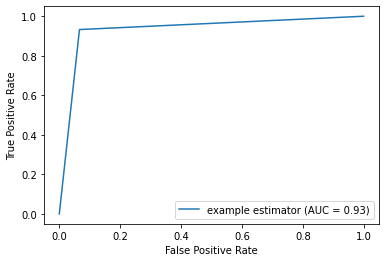

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()